In [ ]:
# Required Libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# ----- 1. Ising Model Simulation (Metropolis Algorithm) -----
def metropolis_step(config, beta):
    L = config.shape[0]
    for _ in range(L**2):
        i, j = np.random.randint(0, L, 2)
        s = config[i, j]
        nb = config[(i+1)%L,j] + config[i,(j+1)%L] + config[(i-1)%L,j] + config[i,(j-1)%L]
        dE = 2 * s * nb
        if dE < 0 or np.random.rand() < np.exp(-dE * beta):
            config[i, j] *= -1
    return config

def simulate_ising(L, T, n_eq=1000, n_sample=100, sample_gap=10):
    beta = 1.0 / T
    config = np.random.choice([-1, 1], size=(L, L))
    # Equilibration
    for _ in range(n_eq):
        config = metropolis_step(config, beta)
    samples = []
    for _ in range(n_sample):
        for _ in range(sample_gap):
            config = metropolis_step(config, beta)
        samples.append(np.copy(config))
    return np.array(samples)

# ----- 2. Dataset Generation -----
def generate_dataset(L, temps, n_sample=100):
    X, y, T_all = [], [], []
    for i, T in enumerate(tqdm(temps, desc="Generating data")):
        configs = simulate_ising(L, T, n_sample=n_sample)
        X.extend(configs)
        y.extend([i] * len(configs))
        T_all.extend([T] * len(configs))
    X = np.array(X)
    y = np.array(y)
    T_all = np.array(T_all)
    return X, y, T_all

# ----- 3. Neural Network -----
class ConfusionNet(nn.Module):
    def __init__(self, L):
        super(ConfusionNet, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(L*L, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)

# ----- 4. Training & Evaluation -----
def train_model(model, X_train, y_train, epochs=10, lr=0.02, l2=0.005):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    loss_fn = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)

    for epoch in range(epochs):
        model.train()
        for i in range(0, len(X_train), 100):
            x_batch = torch.tensor(X_train[i:i+100], dtype=torch.float32).to(device)
            y_batch = torch.tensor(y_train[i:i+100], dtype=torch.long).to(device)

            optimizer.zero_grad()
            output = model(x_batch)
            loss = loss_fn(output, y_batch)
            loss.backward()
            optimizer.step()

def evaluate_model(model, X, y):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y, dtype=torch.long).to(device)
        output = model(X_tensor)
        pred = output.argmax(dim=1)
        acc = (pred == y_tensor).float().mean().item()
    return acc

# ----- 5. Confusion Scheme -----
def confusion_scheme(X, T_arr, T_true=2.27, trial_Tcs=np.linspace(1.0, 3.5, 40), L=20):
    accuracies = []
    for T_c in tqdm(trial_Tcs, desc="Confusion scan"):
        # Assign label based on trial Tc
        y_confuse = (T_arr > T_c).astype(int)
        X_train, X_test, y_train, y_test = train_test_split(X, y_confuse, test_size=0.2)

        model = ConfusionNet(L)
        train_model(model, X_train, y_train)
        acc = evaluate_model(model, X_test, y_test)
        accuracies.append(acc)

    # Plot
    plt.figure(figsize=(6,5))
    plt.plot(trial_Tcs / T_true, accuracies, '-o', label=f'L = {L}')
    plt.axvline(1.0, color='gray', linestyle='--', label="True Tc")
    plt.xlabel(r"$T'_c / T_c$")
    plt.ylabel("Classification Accuracy")
    plt.title("Confusion Scheme for 2D Ising Model (L = 30)")
    plt.legend()
    plt.grid()
    plt.show()


Confusion scan: 100%|██████████| 40/40 [00:22<00:00,  1.78it/s]


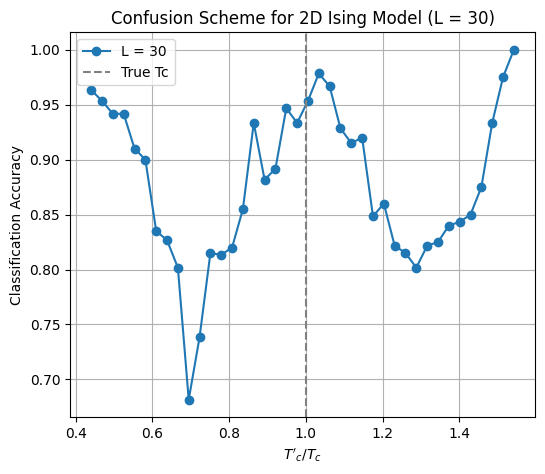

In [ ]:
L = 30 # CHANGE THIS
temps = np.linspace(1.0, 3.5, 30)
X, _, T_arr = generate_dataset(L, temps, n_sample=100)
confusion_scheme(X, T_arr, L=L)